# Классификация изображений (Car Classification)
## Unit 7 Project 5

### Основная идея решения: взять предобученую сеть и дообучить под задачу проекта; на основе рекомендаций улучшить качество модели. 

# Setup

In [1]:
!nvidia-smi

Tue Oct 20 02:52:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
# Обновление pip
# !pip install --upgrade pip
# Обновление tensorflow
!pip install tensorflow - -upgrade
# Загрузка модели efficientnet
!pip install -q efficientnet
# Загружаем обвязку под keras для использования продвинутых библиотек аугментации, например, albuminations
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

     |████████████████████████████████| 1.5 MB 2.9 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.2.3
    Uninstalling pip-20.2.3:
      Successfully uninstalled pip-20.2.3
     |████████████████████████████████| 320.4 MB 22 kB/s s eta 0:00:01    |█████                           | 50.2 MB 57.1 MB/s eta 0:00:05     |████████████▋                   | 126.1 MB 20.7 MB/s eta 0:00:10     |█████████████                   | 131.1 MB 20.7 MB/s eta 0:00:10�█████████▍                 | 144.3 MB 20.7 MB/s eta 0:00:09     |██████████████▋                 | 146.0 MB 20.7 MB/s eta 0:00:09�█████████▊                 | 147.7 MB 20.7 MB/s eta 0:00:09     |███████████████▍                | 153.6 MB 32.5 MB/s eta 0:00:06     |███████████████▋                | 156.0 MB 32.5 MB/s eta 0:00:06     |██████████████████████▏         | 222.4 MB 47.6 MB/s eta 0:00:03     |██████████████████████▍         | 224.1 MB 47.6 MB/s eta 0:00:03
  Attempting uninstall: tensorflow
    F

  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=28062 sha256=b352423c10c4f91020d058502ab1c1d7b18d63ba81a73fca47c9df403bd102b1
  Stored in directory: /tmp/pip-ephem-wheel-cache-2zpf3nan/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
import efficientnet.tfkeras as efn


from ImageDataAugmentor.image_data_augmentor import *
import albumentations

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import PIL
from PIL import ImageOps, ImageFilter

# увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['sf-dl-car-classification']
Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.1
Keras        : 2.4.0


In [4]:
!pip freeze > requirements.txt

In [5]:
EPOCHS = 20  # эпох на обучение 10
BATCH_SIZE = 8  # уменьшаем batch до 8 для работы с моделью EfficientNetB6
LR = 1e-4
VAL_SPLIT = 0.20  # сколько данных выделяем на тест = 20%

CLASS_NUM = 10  # количество классов в нашей задаче
IMG_SIZE = 480  # какого размера подаем изображения в сеть
IMG_CHANNELS = 3   # у RGB 3 канала
input_shape = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/sf-dl-car-classification/'
PATH = "../working/car/"  # рабочая директория

In [6]:
# Устаналиваем конкретное значение random seed для воспроизводимости
# os.makedirs(PATH,exist_ok=False)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
PYTHONHASHSEED = 0

## EDA

In [7]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [9]:
train_df.Category.value_counts()
# распределение классов достаточно равномерное

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

In [10]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile(DATA_PATH+data_zip, "r") as z:
        z.extractall(PATH)

print(os.listdir(PATH))

Распаковываем картинки
['test_upload', 'train']


Пример картинок (random sample)


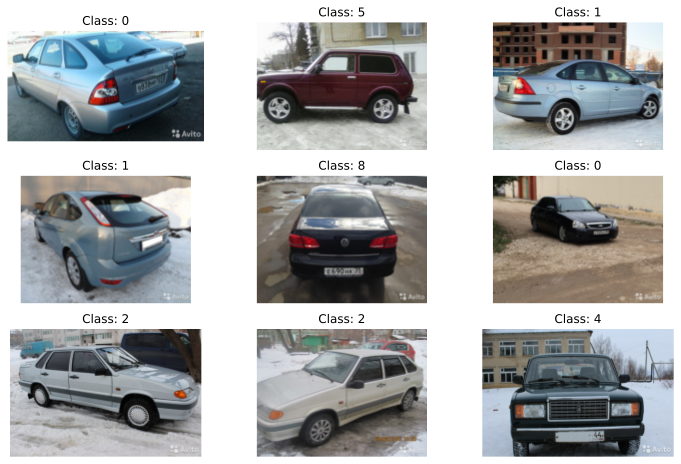

In [11]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12, 8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3, 3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

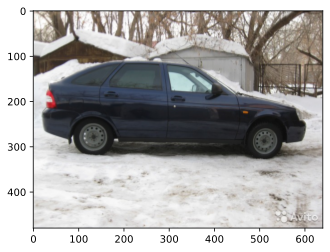

(640, 480)

In [12]:
# образец изображения для анализа
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

# Подготовка данных

## Аугментация данных

In [13]:
# после первых опытов был уменьшен лимит ротации и увеличены значеия кропа
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=10, interpolation=1, border_mode=4,
                          value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=320, width=480),
        albumentations.CenterCrop(height=480, width=320),
    ], p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.1, contrast_limit=0.1)
    ], p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
    rescale=1./255,
    augment=AUGMENTATIONS,
    validation_split=VAL_SPLIT,
)

test_datagen = ImageDataAugmentor(rescale=1./255)

## Generator's

In [14]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training')  # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation')  # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


Пример картинок из train_generator


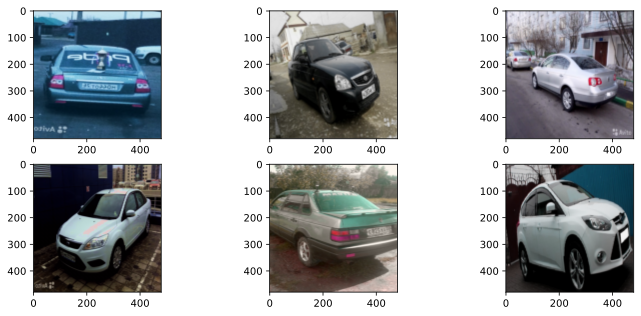

In [15]:
# Пример картинок из генератора
from skimage import io


def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()


x, y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12, 8))

for i in range(0, 6):
    image = x[i]
    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    # plt.axis('off')
plt.show()

## Model

In [16]:
# строим модель на базе предобученной сети EfficientNetB6
base_model = efn.EfficientNetB6(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

165527552/165527152 [==============================] - 2s 0us/step


In [17]:
base_model.summary()

Model: "efficientnet-b6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 480, 480, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 240, 240, 56) 1512        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 240, 240, 56) 224         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 240, 240, 56) 0           stem_bn[0][0]                    
____________________________________________________________________________________

__________________________________________________________________________________________________
block7b_expand_bn (BatchNormali (None, 15, 15, 3456) 13824       block7b_expand_conv[0][0]        
__________________________________________________________________________________________________
block7b_expand_activation (Acti (None, 15, 15, 3456) 0           block7b_expand_bn[0][0]          
__________________________________________________________________________________________________
block7b_dwconv (DepthwiseConv2D (None, 15, 15, 3456) 31104       block7b_expand_activation[0][0]  
__________________________________________________________________________________________________
block7b_bn (BatchNormalization) (None, 15, 15, 3456) 13824       block7b_dwconv[0][0]             
__________________________________________________________________________________________________
block7b_activation (Activation) (None, 15, 15, 3456) 0           block7b_bn[0][0]                 
__________

In [18]:
# Заморозим веса imagenet в базовой модели, чтобы она работала в качестве feature extractor
# и наша голова обучалась делать классификацию на наши 10 классов

base_model.trainable = False

In [19]:
# Устанавливаем новую "голову" (head):
model = M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),)
model.add(L.Dense(512, activation='relu'))
model.add(L.BatchNormalization())  # добавляем Batch-нормализацию
model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Functional) (None, 15, 15, 2304)      40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1180160   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 42,147,474
Trainable params: 1,186,314
Non-trainable params: 40,961,160
_________________________________________________________________


In [21]:
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7fe236c659d0> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7fe236b84ad0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fde70be7e50> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fde70bec910> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fde70beccd0> True


## Fit

In [22]:
LR = 1e-3
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [36]:
checkpoint = ModelCheckpoint('best_model.hdf5', monitor=[
                             'val_accuracy'], verbose=1, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [24]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

389/389 [==============================] - 108s 277ms/step - loss: 2.3158 - accuracy: 0.1238
Accuracy: 12.38%


### Step 1. Обучаем "голову":

In [25]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=20,
    callbacks=callbacks_list
)

Epoch 1/20
1557/1557 [==============================] - ETA: 0s - loss: 1.3461 - accuracy: 0.5275
Epoch 00001: saving model to best_model.hdf5
1557/1557 [==============================] - 532s 342ms/step - loss: 1.3461 - accuracy: 0.5275 - val_loss: 0.7937 - val_accuracy: 0.7189
Epoch 2/20
1557/1557 [==============================] - ETA: 0s - loss: 1.0723 - accuracy: 0.6207
Epoch 00002: saving model to best_model.hdf5
1557/1557 [==============================] - 535s 343ms/step - loss: 1.0723 - accuracy: 0.6207 - val_loss: 0.8008 - val_accuracy: 0.7115
Epoch 3/20
1557/1557 [==============================] - ETA: 0s - loss: 0.9824 - accuracy: 0.6498
Epoch 00003: saving model to best_model.hdf5
1557/1557 [==============================] - 532s 341ms/step - loss: 0.9824 - accuracy: 0.6498 - val_loss: 0.6218 - val_accuracy: 0.7736
Epoch 4/20
1557/1557 [==============================] - ETA: 0s - loss: 0.9515 - accuracy: 0.6635
Epoch 00004: saving model to best_model.hdf5
1557/1557 [======

In [26]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('../working/model_step1.hdf5')
model.load_weights('best_model.hdf5')

In [27]:
scores = model.evaluate_generator(
    test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

389/389 [==============================] - 104s 268ms/step - loss: 0.4469 - accuracy: 0.8417
Accuracy: 84.17%


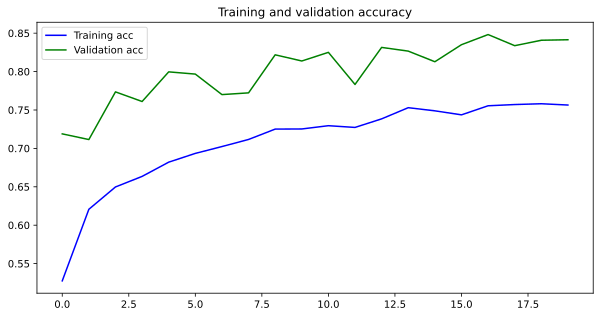

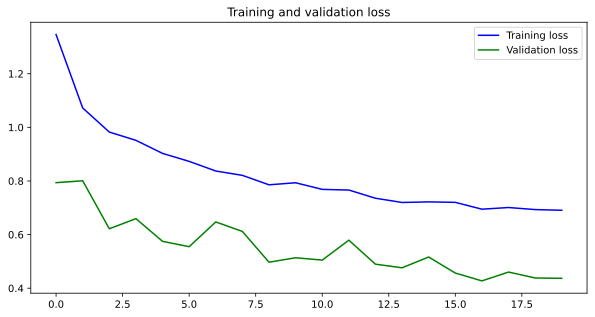

In [28]:
def plot_history(history):
    plt.figure(figsize=(10, 5))
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    # plt.figure()
    plt.figure(figsize=(10, 5))
    # plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


plot_history(history)

## FineTuning

### Step 2.  Замораживаем половину слоев

In [29]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  659


In [30]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [31]:
len(base_model.trainable_variables)

291

In [32]:
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7fe236c659d0> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7fe236b84ad0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fde70be7e50> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fde70bec910> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fde70beccd0> True


In [33]:
LR = 1e-4
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Functional) (None, 15, 15, 2304)      40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1180160   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 42,147,474
Trainable params: 38,882,784
Non-trainable params: 3,264,690
_________________________________________________________________


In [35]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

389/389 [==============================] - 104s 268ms/step - loss: 0.4527 - accuracy: 0.8347
Accuracy: 83.47%


In [ ]:
# Обучаем
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples//test_generator.batch_size,
    epochs=EPOCHS,
    callbacks=callbacks_list
)

Epoch 1/20
1556/1556 [==============================] - ETA: 0s - loss: 0.7252 - accuracy: 0.7701
Epoch 00001: saving model to best_model.hdf5
1556/1556 [==============================] - 712s 457ms/step - loss: 0.7252 - accuracy: 0.7701 - val_loss: 0.2139 - val_accuracy: 0.9323
Epoch 2/20
1556/1556 [==============================] - ETA: 0s - loss: 0.3393 - accuracy: 0.8857
Epoch 00002: saving model to best_model.hdf5
1556/1556 [==============================] - 712s 458ms/step - loss: 0.3393 - accuracy: 0.8857 - val_loss: 0.1753 - val_accuracy: 0.9439
Epoch 3/20
 746/1556 [=============>................] - ETA: 5:12 - loss: 0.2609 - accuracy: 0.9116

In [ ]:
model.save('../working/model_step2.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
plot_history(history)

###  Step 3. Уменьшаем количество замороженных слоев

In [ ]:
# base_model.trainable = True

In [ ]:
# print("Number of layers in the base model: ", len(base_model.layers))

In [ ]:
# base_model.trainable = True

# Fine-tune from this layer onwards
# fine_tune_at = len(base_model.layers)//4

# Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
#   layer.trainable =  False

In [ ]:
# len(base_model.trainable_variables)

In [ ]:
# LR = 1e-5
# model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
# Обучаем
# history = model.fit_generator(
#        train_generator,
#        steps_per_epoch = train_generator.samples//train_generator.batch_size,
#        validation_data = test_generator,
#        validation_steps = test_generator.samples//test_generator.batch_size,
#        epochs = 10,
#        callbacks = callbacks_list
# )

In [ ]:
# model.save('../working/model_step3.hdf5')
# model.load_weights('best_model.hdf5')

In [ ]:
# scores = model.evaluate_generator(test_generator, verbose=1)
# print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
# plot_history(history)

## Step 4

In [ ]:
base_model.trainable = True

In [ ]:
len(base_model.trainable_variables)

In [ ]:
LR = 1e-5
# LR = 1e-6
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
# Обучаем
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples//test_generator.batch_size,
    epochs=20,
    callbacks=callbacks_list
)

In [ ]:
model.save('../working/model_step4.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

## Prediction

In [ ]:
test_sub_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

In [ ]:
test_sub_generator.samples

In [ ]:
test_sub_generator.reset()
predictions = model.predict(
    test_sub_generator, steps=len(test_sub_generator), verbose=1)
predictions = np.argmax(predictions, axis=-1)  # multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v, k) for k, v in label_map.items())  # flip k,v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir = test_sub_generator.filenames
submission = pd.DataFrame(
    {'Id': filenames_with_dir, 'Category': predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/', '')
submission.to_csv('submission.csv', index=False)
print('Save submit')

##  TTA

In [ ]:
model.load_weights('best_model.hdf5')

In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=[0.75, 1.25],
    brightness_range=[0.5, 1.5],
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

In [ ]:
test_sub_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

In [ ]:
tta_steps = 10
predictions = []

for i in range(tta_steps):
    preds = model.predict(test_sub_generator, steps=len(
        test_sub_generator), verbose=1)
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

In [ ]:
predictions = np.argmax(pred, axis=-1)  # multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v, k) for k, v in label_map.items())  # flip k,v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir = test_sub_generator.filenames
submission = pd.DataFrame(
    {'Id': filenames_with_dir, 'Category': predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/', '')
submission.to_csv('submission_tta.csv', index=False)
print('Save submit')

## Clean

In [ ]:
# Clean PATH
import shutil
shutil.rmtree(PATH)